In [1]:
# Modules for debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler


# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

# Custom modules
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.SubjectDataset import *

np.set_printoptions(precision=2, suppress=True)

In [11]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/adni1-complete-3T-processed"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the data of interest
data_string = 'volumes'

# Dictionary key representing the disease labels
labels_string = 'research_group'

downsample_majority=True

test_size = 0.2

In [12]:
dataset = SubjectDataset(data_path, selected_labels, downsample_majority=downsample_majority)

In [13]:

volumes, labels = [], []

for subject in range(len(dataset)):
    
    volumes.append(dataset.__getitem__(subject)['volumes'])
    
    labels.append(dataset.__getitem__(subject)['research_group'])

# standardise volumes
# scaler = StandardScaler()

volumes_train, volumes_test, labels_train, labels_test = train_test_split(volumes, labels, test_size=0.2)

In [14]:
print(np.unique(labels, return_counts=True))

(array([0, 1]), array([160, 160]))


In [17]:
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=2)

cv = StratifiedKFold(n_splits=10, shuffle=True)

cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {np.mean(cv_scores)}')
print(f'Standard deviation of cross-validation accuracy: {np.std(cv_scores)}')

Cross-validation accuracy scores: [1.   0.97 0.97 0.97 0.94 1.   1.   1.   1.   1.  ]
Mean cross-validation accuracy: 0.984375
Standard deviation of cross-validation accuracy: 0.02096313728906053


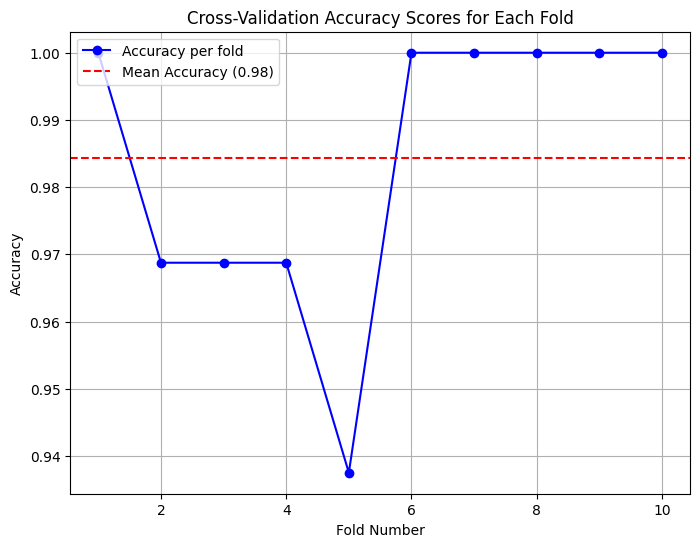

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()